## Static dataset creation
This notebook walks through how to use the modules to create and save a static dataset for use in all of the statistical and ML methods. The method-focused notebooks show how to import and utilize this static dataset in inference.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scripts.io import DataLoader, DataPreparation

Use the `DataPreparation()` class from `io` to simulate some linear data with two levels of noise.

Low noise is $\sigma = 1$. High noise is $\sigma = 10$. Both use the same input xs and same priors. Let's simulate the low noise first.

In [2]:
data = DataPreparation()

In [11]:
size_df = 1000
data.sample_params_from_prior(size_df)

In [12]:
sigma = 1
data.simulate_data(data.params,
                   sigma, 
                   'linear_homogeneous'
                    )

Linear simulation data generated.


Let's take a look at this simulated dataset.

In [13]:
print(np.shape(data.output[0]))
data.output

torch.Size([101])


tensor([[-2.4224e-02,  5.6199e+00,  1.1639e+01,  ...,  5.5604e+02,
          5.6288e+02,  5.6719e+02],
        [-2.6385e+00,  3.0326e+00,  1.1974e+01,  ...,  7.0759e+02,
          7.1117e+02,  7.2146e+02],
        [ 6.7532e-01,  2.7800e+00,  9.0001e+00,  ...,  4.2014e+02,
          4.2466e+02,  4.2954e+02],
        ...,
        [ 6.7184e+00,  1.4456e+01,  2.3392e+01,  ...,  7.2387e+02,
          7.2972e+02,  7.3688e+02],
        [-1.1339e+00,  1.0373e+01,  1.8281e+01,  ...,  8.6114e+02,
          8.7188e+02,  8.8211e+02],
        [-7.5208e+00, -4.7459e+00, -1.9856e+00,  ...,  2.8713e+02,
          2.8902e+02,  2.9290e+02]])

In [14]:
data.params

tensor([[ 5.6734,  0.6882],
        [ 7.2386, -3.3923],
        [ 4.2837,  0.7198],
        ...,
        [ 7.2893,  8.0534],
        [ 8.8033,  0.3763],
        [ 2.9963, -6.8215]])

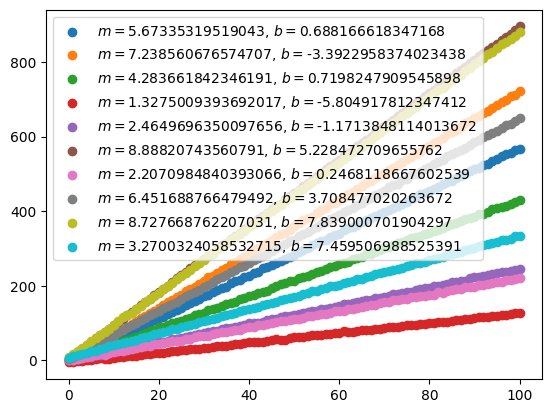

In [15]:
plt.clf()
for i in range(10):
    plt.scatter(data.input, data.output[i],
                label = f'$m = ${data.params[i][0].numpy()}, $b = ${data.params[i][1].numpy()}')
plt.legend()
plt.show()
    

In [16]:
# now make it into a dataframe
dict = data.get_dict()
dict

{'params': tensor([[ 5.6734,  0.6882],
         [ 7.2386, -3.3923],
         [ 4.2837,  0.7198],
         ...,
         [ 7.2893,  8.0534],
         [ 8.8033,  0.3763],
         [ 2.9963, -6.8215]]),
 'inputs': array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
         11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
         22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
         33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
         44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
         55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
         66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
         77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
         88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
         99., 100.]),
 'output': tensor([[-2.4224e-02,  5.6199e+00,  1.1639e+01,  ...,  5.5604e+02,
           5.6288e+02,  

## Save the data to h5

In [9]:
saver = DataLoader()

In [17]:
# save the dataframe
filepath = '../data/'
saver.save_data_h5('linear_sigma_'+str(sigma)+'_size_'+str(size_df), dict)